In [31]:
# Import and load required packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [32]:
# Define a function to fetch forecast data from the API
def fetch_forecast_data(location, days):
    api_key = "f1a1afe0cebd41a68de112754250301"  # API key to be embedded into url
    url = f"http://api.weatherapi.com/v1/forecast.json?key={api_key}&q=metar:{location}&days={days}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json() #.json response from API (as set in URL - can be changed for a .html)
    except requests.exceptions.RequestException as e:
        messagebox.showerror("Error", f"Failed to fetch data: {e}")
        return None

In [33]:
# Create a fucntion that processes and stores daily data into a dataframe
def process_daily_data(data):
    forecast_days = data['forecast']['forecastday'] # Dictionary to access correct part of .json response
    daily_data = [] # Create empty list to store data in
    for day in forecast_days:
        daily_data.append({
            "Date": day['date'],
            "Max Temp (C)": day['day']['maxtemp_c'],
            "Min Temp (C)": day['day']['mintemp_c'],
            "Avg Temp (C)": day['day']['avgtemp_c'],
            "Condition": day['day']['condition']['text']
        })
    return pd.DataFrame(daily_data) # Return list as df when called later

In [34]:
# Create a function that processes & stores hourly data into a dataframe
def process_hourly_data(data):
    forecast_days = data['forecast']['forecastday'] # Dictionary to access correct part of .json response
    hourly_data = [] # Create empty list to store data in
    for day in forecast_days:
        for hour in day['hour']:
            hourly_data.append({
                "DateTime": hour['time'],
                "Temperature (C)": hour['temp_c'],
                "Wind (mph)": hour['wind_mph'],
                "Gusts (mph)": hour['gust_mph'],
                "Visibility (miles)": hour['vis_miles'],
                "Humidity (%)": hour['humidity']
            })
    return pd.DataFrame(hourly_data) # Return list as df when called later

In [37]:
# Define a function that displays the generated vis' within tabs in the GUI
def show_visualizations():
    location = location_entry.get()
    days = days_entry.get()

    if not location or not days.isdigit() or int(days) < 1 or int(days) > 10:
        messagebox.showerror("Error!", "Either the ICAO code or number of forecast days are invalid! Forecast days should be 1-10")
        return # Error handling regarding user input

    days = int(days)
    data = fetch_forecast_data(location, days) # Run function to run API with user values embedded
    if not data:
        return

    # Run processing functions to return .json API results in dataframes
    daily_forecast_df = process_daily_data(data)
    hourly_forecast_df = process_hourly_data(data)

    # Ensure tabs are clear from any previous work
    for widget in daily_tab.winfo_children():
        widget.destroy()
    for widget in hourly_tab.winfo_children():
        widget.destroy()

    # Use system info to calculate and dynamically adjust figure size
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    fig_width = max(8, screen_width // 150)
    fig_height = max(5, screen_height // 200)

    # Create daily temperature range plot
    fig1, ax1 = plt.subplots(figsize=(fig_width, fig_height))
    sns.lineplot(x="Date", y="Max Temp (C)", data=daily_forecast_df, label="Max Temp", ax=ax1)
    sns.lineplot(x="Date", y="Min Temp (C)", data=daily_forecast_df, label="Min Temp", ax=ax1)
    ax1.set_title(f"Daily Temperature Range for {location}")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Temperature (C)")
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    
    # Use tight layout to ensure axis labels are fully visible
    plt.tight_layout()

    # Embed daily plot in daily_tab
    canvas1 = FigureCanvasTkAgg(fig1, daily_tab)
    canvas1.get_tk_widget().pack(padx=10, pady=10)
    canvas1.draw()

    # Create hourly temperature trend plot
    hourly_forecast_df['DateTime'] = pd.to_datetime(hourly_forecast_df['DateTime'])
    fig2, ax2 = plt.subplots(figsize=(fig_width, fig_height))
    sns.lineplot(x="DateTime", y="Temperature (C)", data=hourly_forecast_df, ax=ax2)
    ax2.set_title(f"Hourly Temperature Forecast for {location}")
    ax2.set_xlabel("DateTime")
    ax2.set_ylabel("Temperature (C)")
    ax2.tick_params(axis='x', rotation=45)
    
    # Use tight layout to ensure axis labels are fully visible
    plt.tight_layout()

    # Embed hourly plot in hourly_tab
    canvas2 = FigureCanvasTkAgg(fig2, hourly_tab)
    canvas2.get_tk_widget().pack(padx=10, pady=10)
    canvas2.draw()
    
    # Create wind speed plot that has plotted lines for sustained and gusts
    hourly_forecast_df['DateTime'] = pd.to_datetime(hourly_forecast_df['DateTime'])
    fig3, ax3 = plt.subplots(figsize=(fig_width, fig_height))
    sns.lineplot(x="DateTime", y="Wind (mph)", data=hourly_forecast_df, label = "Sustained", ax=ax3)
    sns.lineplot(x="DateTime", y="Gusts (mph)", data=hourly_forecast_df, label = "Gusts", ax=ax3)
    ax3.axhline(y=25, color = 'red', ls=':', label = "Operational Limit") # Add reference line for where wind exceeds a certain value
    ax3.set_title(f"Hourly Sustained & Gusting Winds Speed Forecast for {location}")
    ax3.set_xlabel("DateTime")
    ax3.set_ylabel("Wind (mph)")
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend()
    
    # Use tight layout to ensure axis labels are fully visible
    plt.tight_layout()

    # Embed wind speed plot in the applicable tab
    canvas3 = FigureCanvasTkAgg(fig3, wind_speed_tab)
    canvas3.get_tk_widget().pack(padx=10, pady=10)
    canvas3.draw()

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

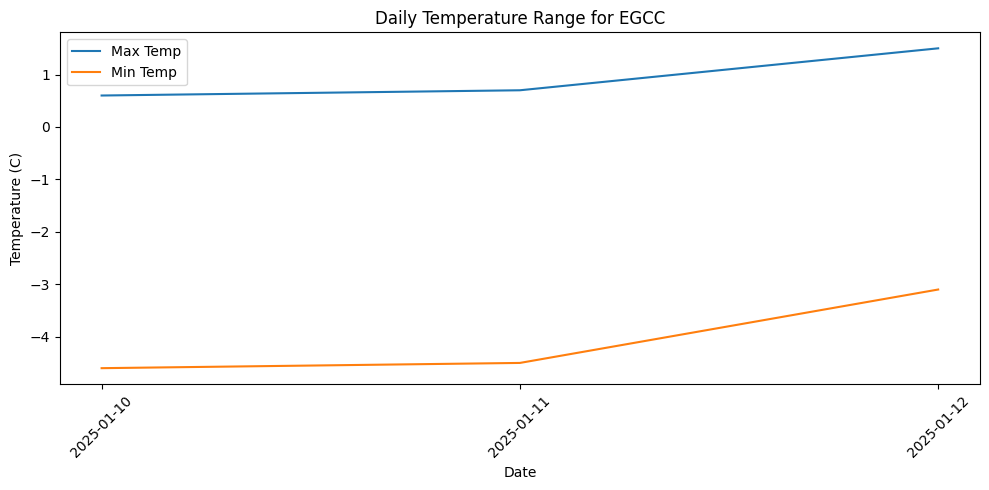

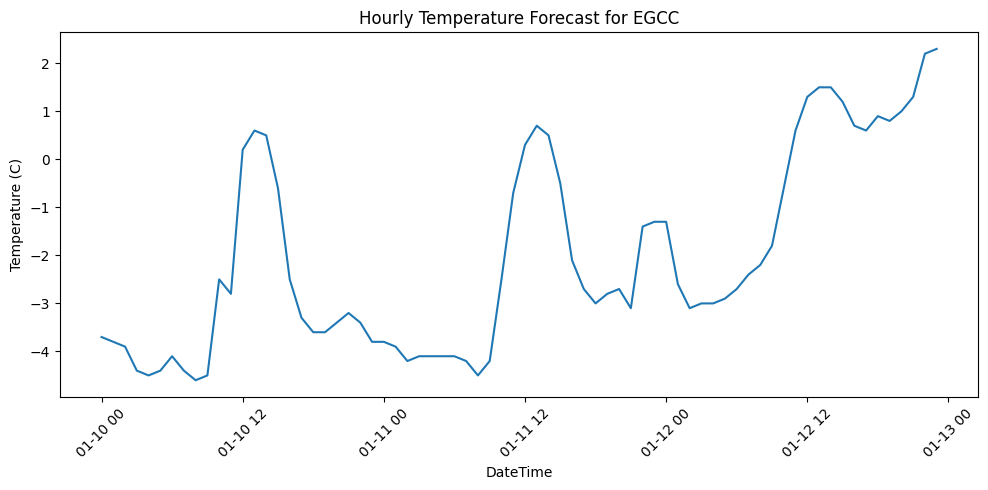

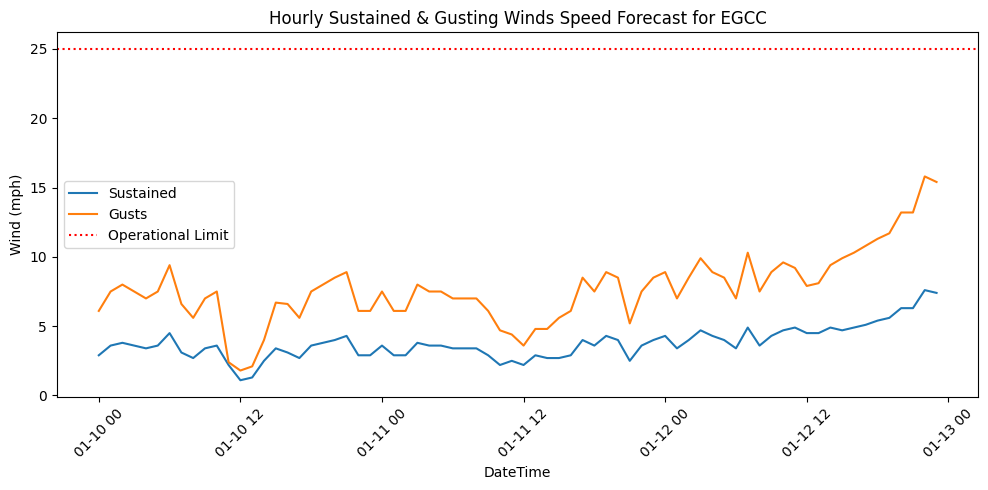

In [ ]:
# Setup GUI/app that the user will interact with & view resulting visualisations in
root = tk.Tk()
root.title("Weather & METAR Forecast")

# Input frame - first pop up
input_frame = ttk.Frame(root, padding="10")
input_frame.grid(row=0, column=0, sticky="ew")

# Type-in input box for location - in this case an ICAO Aerodrome code
tk.Label(input_frame, text="Aerodrome (Please enter an ICAO code e.g. EGLL):").grid(row=0, column=0, padx=10, pady=5)
location_entry = ttk.Entry(input_frame)
location_entry.grid(row=0, column=1, padx=10, pady=5)

# Type-in input box for number of forecast days - error handled in case user types in non-integer value
tk.Label(input_frame, text="Forecast Days (1-10):").grid(row=1, column=0, padx=10, pady=5)
days_entry = ttk.Entry(input_frame)
days_entry.grid(row=1, column=1, padx=10, pady=5)

# Button to run "show_visualisations" function, which will then return the graphs
visualize_button = ttk.Button(input_frame, text="Show Visualizations", command=show_visualizations)
visualize_button.grid(row=2, column=0, columnspan=2, pady=10)

# Create notebooks for each visualisation tabs
notebook = ttk.Notebook(root)
notebook.grid(row=1, column=0, sticky="nsew")

# Tab for each vis - adjust as multiple vis' in one area was too tight
daily_tab = ttk.Frame(notebook)
hourly_tab = ttk.Frame(notebook)
wind_speed_tab = ttk.Frame(notebook)

# Labels for tabs
notebook.add(daily_tab, text="Daily Forecast")
notebook.add(hourly_tab, text="Hourly Forecast") 
notebook.add(wind_speed_tab, text="Wind Speed") # Tab names

# Set row & column weights
root.rowconfigure(1, weight=1)
root.columnconfigure(0, weight=1)

# Run the full GUI/app
root.mainloop()